In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import numpy as np
import geopandas as gpd
import seaborn as sns
from geopandas.tools import sjoin
import contextily as ctx
from shapely import wkt

# 1. Fig.3
London in years. I included only Jan from 2020, see list "london_userperf_loc"

In [7]:
london_homeantenna_loc = 'datasets/012020/home_ldn_onlysmartphones.csv'

london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'

#MMYYYY_list = ['102018','112018','042019','072019','102019','012020','022020','032020','042020']
MMYYYY_list = ['2018','2018','2019','2019','2019','2020']

london_userperf_loc = ['datasets/102018/userperf_2018_10.csv', 
                       'datasets/112018/userperf_2018_11.csv', 
                       'datasets/042019/userperf_ldn_2019_04.csv', 
                       'datasets/072019/userperf_ldn_2019_07.csv', 
                       'datasets/102019/userperf_ldn_2019_10.csv',
                       'datasets/012020/userperf_ldn_2020_jan.csv']#,
                       #'datasets/022020/userperf_ldn_feb.csv',
                       #'datasets/032020/userperf_ldn_mar.csv',
                       #'datasets/042020/userperf_ldn_apr.csv']

london_vdt_loc = 'datasets/VDT/newvdt202002_london.csv'
birmingham_vdt_loc = 'datasets/VDT/newvdt202002_birmingam.csv'
liverpool_vdt_loc = 'datasets/VDT/newvdt202002_liverpool.csv'

london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'
birmingham_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_pd.csv'
liverpool_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_pd.csv'

In [3]:
#
# read all files to 1 dataframe
#

london_userperf_pd = pd.read_csv(london_userperf_loc[0], index_col=False)
london_userperf_pd['Year'] = MMYYYY_list[0]
for loc,dt in zip(london_userperf_loc[1:], MMYYYY_list[1:]):
    temp = pd.read_csv(loc, index_col=False)
    temp['Year'] = dt
    london_userperf_pd = london_userperf_pd.append(temp, ignore_index=True)

In [4]:
#
# filter(by merge) dataframe with home_antenna(residents) dataset and add(by merger) LSOA IMD values corresponding to each antenna
#

london_homeantenna_pd = pd.read_csv(london_homeantenna_loc, index_col=False)
london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)

london_userperf_pd = pd.merge(london_userperf_pd, london_homeantenna_pd, on='device_id', how='inner')
london_userperf_pd = pd.merge(london_userperf_pd, london_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

In [5]:
#
# normalization of values by 90th percentile
#

for column in ['avg(rtt4g_avg)', 'avg(retx4g_avg)', 'avg(bytesall)']:
    for year in ['2018', '2019', '2020']:
        london_userperf_pd.loc[london_userperf_pd['Year']==year,column] = london_userperf_pd.loc[london_userperf_pd['Year']==year,column]/london_userperf_pd.loc[london_userperf_pd['Year']==year,column].quantile(.9)#.max()    
london_userperf_pd['sum(bytes4g)_ratio'] = london_userperf_pd['sum(bytes4g)']/london_userperf_pd['sum(bytesall)']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


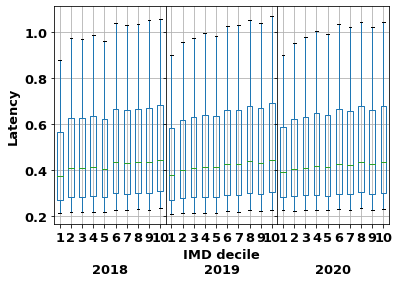

In [6]:
#
# uncoment the plot you want to plot/save
#

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.weight':'bold', 'axes.labelweight' : "bold"})

fig, axes = plt.subplots(ncols=3, sharey=True)
fig.subplots_adjust(wspace=0)

# for ax, year in zip(axes, ['2018', '2019', '2020']):
#     london_userperf_pd[london_userperf_pd['Year']==year].pivot(columns='IMDDecil', values='sum(bytes4g)_ratio').boxplot(whis=[10,90],showfliers =False,ax=ax)
#     ax.set_ylim([0,1])
#     ax.margins(0.05) # Optional
#     ax.set_xlabel('\n'+year)
# axes[0].set_ylabel('4G time ratio')
# axes[1].set_xlabel('IMD decile\n2019')
# fig.savefig('plots/nw_quality_acc_soceco_cls_london_a).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# for ax, year in zip(axes, ['2018', '2019', '2020']):
#     london_userperf_pd[london_userperf_pd['Year']==year].pivot(columns='IMDDecil', values='avg(retx4g_avg)').boxplot(whis=[10,90],showfliers =False,ax=ax)
#     ax.margins(0.05) # Optional
#     ax.set_ylim([0,1.2])
#     ax.set_xlabel('\n'+year)
# axes[0].set_ylabel('Pkt retx [freq]')
# axes[1].set_xlabel('IMD decile\n2019')
# fig.savefig('plots/nw_quality_acc_soceco_cls_london_b).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

for ax, year in zip(axes, ['2018', '2019', '2020']):
    london_userperf_pd[london_userperf_pd['Year']==year].pivot(columns='IMDDecil', values='avg(rtt4g_avg)').boxplot(whis=[10,90],showfliers=False,ax=ax)
    ax.margins(0.05) # Optional
    #ax.set_ylim([0,1.6])
    ax.set_xlabel('\n'+year)
axes[0].set_ylabel('Latency')
axes[1].set_xlabel('IMD decile\n2019')
fig.savefig('plots/nw_quality_acc_soceco_cls_london_c).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# 2. Fig. 4 & Fig. 6
Common code for both figures.  
Same logic for every code section as for Section 1.

In [70]:
london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'
birmingham_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_pd.csv'
liverpool_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_pd.csv'

london_homeantenna_loc = 'datasets/012020/home_ldn_onlysmartphones.csv'
birmingham_homeantenna_loc = 'datasets/012020/home_birm_onlysmartphones.csv'
liverpool_homeantenna_loc = 'datasets/012020/home_lpool_onlysmartphones.csv'

london_userperf_loc = 'datasets/012020/userperf_ldn_2020_jan.csv'
birmingham_userperf_loc = 'datasets/012020/userperf_birm_2020_jan.csv'
liverpool_userperf_loc = 'datasets/012020/userperf_lpool_2020_jan.csv'

In [ ]:
london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)
london_antenna_imd_pd = london_antenna_imd_pd[london_antenna_imd_pd['generation']=='4G']
birmingham_antenna_imd_pd = pd.read_csv(birmingham_antenna_imd_loc, index_col=False)
birmingham_antenna_imd_pd = birmingham_antenna_imd_pd[birmingham_antenna_imd_pd['generation']=='4G']
liverpool_antenna_imd_pd = pd.read_csv(liverpool_antenna_imd_loc, index_col=False)
liverpool_antenna_imd_pd = liverpool_antenna_imd_pd[liverpool_antenna_imd_pd['generation']=='4G']

In [71]:
london_userperf_pd = pd.read_csv(london_userperf_loc, index_col=False)
birmingham_userperf_pd = pd.read_csv(birmingham_userperf_loc, index_col=False)
liverpool_userperf_pd = pd.read_csv(liverpool_userperf_loc, index_col=False)

london_homeantenna_pd = pd.read_csv(london_homeantenna_loc, index_col=False)
birmingham_homeantenna_pd = pd.read_csv(birmingham_homeantenna_loc, index_col=False)
liverpool_homeantenna_pd = pd.read_csv(liverpool_homeantenna_loc, index_col=False)

london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)
birmingham_antenna_imd_pd = pd.read_csv(birmingham_antenna_imd_loc, index_col=False)
liverpool_antenna_imd_pd = pd.read_csv(liverpool_antenna_imd_loc, index_col=False)

london_userperf_pd = pd.merge(london_userperf_pd, london_homeantenna_pd, on='device_id', how='inner')
london_userperf_pd = pd.merge(london_userperf_pd, london_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

birmingham_userperf_pd = pd.merge(birmingham_userperf_pd, birmingham_homeantenna_pd, on='device_id', how='inner')
birmingham_userperf_pd = pd.merge(birmingham_userperf_pd, birmingham_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

liverpool_userperf_pd = pd.merge(liverpool_userperf_pd, liverpool_homeantenna_pd, on='device_id', how='inner')
liverpool_userperf_pd = pd.merge(liverpool_userperf_pd, liverpool_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

## 2.1. Fig 4 specific part

In [72]:
for column in ['avg(rtt4g_avg)', 'avg(retx4g_avg)', 'avg(bytesall)']:
    london_userperf_pd[column] = london_userperf_pd[column]/london_userperf_pd[column].quantile(.9)#.max()
    birmingham_userperf_pd[column] = birmingham_userperf_pd[column]/birmingham_userperf_pd[column].quantile(.9)#.max()
    liverpool_userperf_pd[column] = liverpool_userperf_pd[column]/liverpool_userperf_pd[column].quantile(.9)#.max()
    
london_userperf_pd['sum(bytes4g)_ratio'] = london_userperf_pd['sum(bytes4g)']/london_userperf_pd['sum(bytesall)']
birmingham_userperf_pd['sum(bytes4g)_ratio'] = birmingham_userperf_pd['sum(bytes4g)']/birmingham_userperf_pd['sum(bytesall)']
liverpool_userperf_pd['sum(bytes4g)_ratio'] = liverpool_userperf_pd['sum(bytes4g)']/liverpool_userperf_pd['sum(bytesall)']

In [73]:
#
# I merged the 3 cities to 1 dataframe (london_userperf_pd) so it's easiet to iterate while plotting
#

london_userperf_pd['city'] = 'London'
birmingham_userperf_pd['city'] = 'Birmingham'
liverpool_userperf_pd['city'] = 'Liverpool'

london_userperf_pd = london_userperf_pd.append(birmingham_userperf_pd, ignore_index=True)
london_userperf_pd = london_userperf_pd.append(liverpool_userperf_pd, ignore_index=True)

Text(0.5, 0, 'IMD decile\nBirmingham')

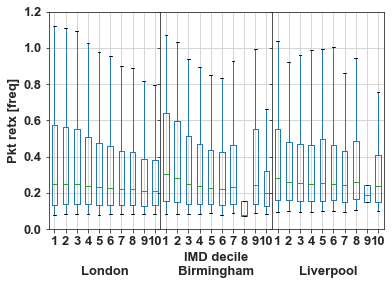

In [66]:
#
# again, ucomment the plot you want to plot/save
#

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.weight':'bold', 'axes.labelweight' : "bold"})

fig, axes = plt.subplots(ncols=3, sharey=True)
fig.subplots_adjust(wspace=0)

# for ax, city in zip(axes, ['London', 'Birmingham', 'Liverpool']):
#     london_userperf_pd[london_userperf_pd['city']==city].pivot(columns='IMDDecil', values='sum(bytes4g)_ratio').boxplot(whis=[10,90],showfliers =False,ax=ax)
#     ax.margins(0.05) # Optional
#     ax.set_xlabel('\n'+city)
# axes[0].set_ylabel('4G time ratio')
# axes[1].set_xlabel('IMD decile\nBirmingham')
# fig.savefig('plots/nw_quality_acc_soceco_cls_a).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

for ax, city in zip(axes, ['London', 'Birmingham', 'Liverpool']):
    london_userperf_pd[london_userperf_pd['city']==city].pivot(columns='IMDDecil', values='avg(retx4g_avg)').boxplot(whis=[10,90],showfliers =False,ax=ax)
    ax.margins(0.05) # Optional
    ax.set_ylim([0,1.2])
    ax.set_xlabel('\n'+city)
axes[0].set_ylabel('Pkt retx [freq]')
axes[1].set_xlabel('IMD decile\nBirmingham')
fig.savefig('plots/nw_quality_acc_soceco_cls_b).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# for ax, city in zip(axes, ['London', 'Birmingham', 'Liverpool']):
#     london_userperf_pd[london_userperf_pd['city']==city].pivot(columns='IMDDecil', values='avg(rtt4g_avg)').boxplot(whis=[10,90],showfliers=False,ax=ax)
#     ax.margins(0.05) # Optional
#     ax.set_ylim([0,1.6])
#     ax.set_xlabel('\n'+city)
# axes[0].set_ylabel('Latency')
# axes[1].set_xlabel('IMD decile\nBirmingham')
# fig.savefig('plots/nw_quality_acc_soceco_cls_c).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

## 2.2. Fig. 6 specific part
Same logic as previous subsection, I just filtered 5GB data exchange users and not normalized the columns, that's all.

In [119]:
london_userperf_pd['city'] = 'London'
birmingham_userperf_pd['city'] = 'Birmingham'
liverpool_userperf_pd['city'] = 'Liverpool'

london_userperf_pd = london_userperf_pd.append(birmingham_userperf_pd, ignore_index=True)
london_userperf_pd = london_userperf_pd.append(liverpool_userperf_pd, ignore_index=True)

In [120]:
london_users = london_userperf_pd.groupby(['IMDDecil','city'])['device_id'].count()
london_users5gb = london_userperf_pd.loc[london_userperf_pd['sum(bytesall)'] >5000000000].groupby(['IMDDecil', 'city'])['device_id'].count()/london_users

london_users5gb = london_users5gb.reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  del sys.path[0]


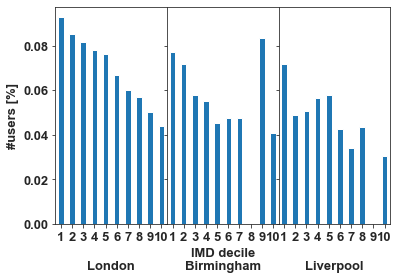

In [127]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.weight':'bold', 'axes.labelweight' : "bold"})

fig, axes = plt.subplots(ncols=3, sharey=True)
fig.subplots_adjust(wspace=0)

for ax, city in zip(axes, ['London', 'Birmingham', 'Liverpool']):
    london_users5gb[london_users5gb['city']==city].plot.bar(x='IMDDecil', y='device_id',ax=ax,rot=0,legend=False)
    ax.margins(0.05) # Optional
    ax.set_xlabel('\n'+city)
axes[0].set_ylabel('#users [%]')
axes[1].set_xlabel('IMD decile\nBirmingham')
fig.savefig('plots/data_consump_among_dec.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# 3. Fig 5 b-c
Same plotting logic.

In [146]:
cdres_london_loc = 'datasets/012020/cd_res_ldn_01.csv'
cdnonres_london_loc = 'datasets/012020/cd_nres_ldn_01.csv'
cdres_birmingham_loc = 'datasets/012020/cd_res_birm_01.csv'
cdnonres_birmingham_loc = 'datasets/012020/cd_nres_birm_01.csv'
cdres_liverpool_loc = 'datasets/012020/cd_res_lpool_01.csv'
cdnonres_liverpool_loc = 'datasets/012020/cd_nres_lpool_01.csv'

london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'
birmingham_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_pd.csv'
liverpool_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_pd.csv'

In [147]:
london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)
london_antenna_imd_pd = london_antenna_imd_pd[london_antenna_imd_pd['generation']=='4G']
birmingham_antenna_imd_pd = pd.read_csv(birmingham_antenna_imd_loc, index_col=False)
birmingham_antenna_imd_pd = birmingham_antenna_imd_pd[birmingham_antenna_imd_pd['generation']=='4G']
liverpool_antenna_imd_pd = pd.read_csv(liverpool_antenna_imd_loc, index_col=False)
liverpool_antenna_imd_pd = liverpool_antenna_imd_pd[liverpool_antenna_imd_pd['generation']=='4G']

In [148]:
london_cd_res_pd = pd.read_csv(cdres_london_loc, index_col=False)
london_cd_res_pd['city'] = 'London'
london_cd_res_pd = london_cd_res_pd.merge(london_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

london_cd_nres_pd = pd.read_csv(cdnonres_london_loc, index_col=False)
london_cd_nres_pd['city'] = 'London'
london_cd_nres_pd = london_cd_nres_pd.merge(london_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

birmingham_cd_res_pd = pd.read_csv(cdres_birmingham_loc, index_col=False)
birmingham_cd_res_pd['city'] = 'Birmingham'
birmingham_cd_res_pd = birmingham_cd_res_pd.merge(birmingham_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

birmingham_cd_nres_pd = pd.read_csv(cdnonres_birmingham_loc, index_col=False)
birmingham_cd_nres_pd['city'] = 'Birmingham'
birmingham_cd_nres_pd = birmingham_cd_nres_pd.merge(birmingham_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

liverpool_cd_res_pd = pd.read_csv(cdres_liverpool_loc, index_col=False)
liverpool_cd_res_pd['city'] = 'Liverpool'
liverpool_cd_res_pd = liverpool_cd_res_pd.merge(liverpool_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

liverpool_cd_nres_pd = pd.read_csv(cdnonres_liverpool_loc, index_col=False)
liverpool_cd_nres_pd['city'] = 'Liverpool'
liverpool_cd_nres_pd = liverpool_cd_nres_pd.merge(liverpool_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

london_cd_res_pd = london_cd_res_pd.append(birmingham_cd_res_pd, ignore_index=True)
london_cd_res_pd = london_cd_res_pd.append(liverpool_cd_res_pd, ignore_index=True)

london_cd_nres_pd = london_cd_nres_pd.append(birmingham_cd_nres_pd, ignore_index=True)
london_cd_nres_pd = london_cd_nres_pd.append(liverpool_cd_nres_pd, ignore_index=True)

In [149]:
#
# this is the only different part, I add nonres and res data and assign it to nonres. Why? simple tricks : 
# so the nonres data "looks like" stacked n top of the the res data
#

london_density_res_avg_per_imd = london_cd_res_pd.groupby(['IMDDecil','city'])['avg_sum_time'].mean()/3600000
london_density_nonres_avg_per_imd = london_cd_nres_pd.groupby(['IMDDecil','city'])['avg_sum_time'].mean()/3600000
london_density_nonres_avg_per_imd = (london_density_nonres_avg_per_imd + london_density_res_avg_per_imd).reset_index()
london_density_res_avg_per_imd = london_density_res_avg_per_imd.reset_index()


london_devcnt_res_avg_per_imd = london_cd_res_pd.groupby(['IMDDecil','city'])['avg_count_device_id'].mean()
london_devcnt_nonres_avg_per_imd = london_cd_nres_pd.groupby(['IMDDecil','city'])['avg_count_device_id'].mean()
london_devcnt_nonres_avg_per_imd = (london_devcnt_nonres_avg_per_imd + london_devcnt_res_avg_per_imd).reset_index()
london_devcnt_res_avg_per_imd = london_devcnt_res_avg_per_imd.reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


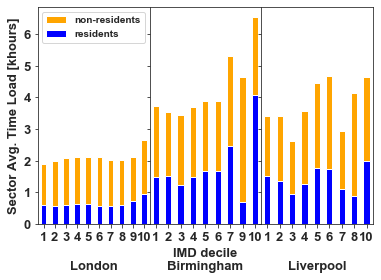

In [156]:
#
# again, uncomment which one you like
#

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.weight':'bold', 'axes.labelweight' : "bold"})

fig, axes = plt.subplots(ncols=3, sharey=True)
fig.subplots_adjust(wspace=0)

# for ax, city in zip(axes, ['London', 'Birmingham', 'Liverpool']):
#     london_devcnt_nonres_avg_per_imd[london_devcnt_nonres_avg_per_imd['city']==city].plot.bar(label='non-residents', x='IMDDecil', y='avg_count_device_id',ax=ax,rot=0,legend=False,color='orange')
#     london_devcnt_res_avg_per_imd[london_devcnt_nonres_avg_per_imd['city']==city].plot.bar(label='residents', x='IMDDecil', y='avg_count_device_id',ax=ax,rot=0,legend=False,color='blue')
#     ax.margins(0.05) # Optional
#     ax.set_xlabel('\n'+city)
# axes[0].set_ylabel('Avg. device count')
# axes[1].set_xlabel('IMD decile\nBirmingham')
# axes[0].legend(fontsize=10)
# fig.savefig('plots/aggsec_lvl_anls_b).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

for ax, city in zip(axes, ['London', 'Birmingham', 'Liverpool']):
    london_density_nonres_avg_per_imd[london_density_nonres_avg_per_imd['city']==city].plot.bar(label='non-residents', x='IMDDecil', y='avg_sum_time',ax=ax,rot=0,legend=False,color='orange')
    london_density_res_avg_per_imd[london_density_nonres_avg_per_imd['city']==city].plot.bar(label='residents', x='IMDDecil', y='avg_sum_time',ax=ax,rot=0,legend=False,color='blue')
    ax.margins(0.05) # Optional
    ax.set_xlabel('\n'+city)
axes[0].set_ylabel('Sector Avg. Time Load [khours]')
axes[1].set_xlabel('IMD decile\nBirmingham')
axes[0].legend(fontsize=10)
fig.savefig('plots/aggsec_lvl_anls_c).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# 4. Fig. 5 a
A bit more complex, I idea : I calculate center/centroid of each LSOA polygon, then calculate distance to all antennas from each centroid and take the closest one. The code is a bit more complicated as I did only minor modifications from the code where I calcuated avg distance to closest 3 and 5 antennas.

In [162]:
london_lsoa_2019_loc = 'datasets/UK_LSOA/london_lsoa_2019_gpd.geojson'
birmingham_lsoa_2019_loc ='datasets/UK_LSOA/birmingham_lsoa_2019_gpd.geojson'
liverpool_lsoa_2019_loc = 'datasets/UK_LSOA/liverpool_lsoa_2019_gpd.geojson'

london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'
birmingham_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_pd.csv'
liverpool_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_pd.csv'

In [163]:
london_lsoa_2019_gpd = gpd.read_file(london_lsoa_2019_loc)
birmingham_lsoa_2019_gpd = gpd.read_file(birmingham_lsoa_2019_loc)
liverpool_lsoa_2019_gpd = gpd.read_file(liverpool_lsoa_2019_loc)

# filter 4G antennas
london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)
london_antenna_imd_pd = london_antenna_imd_pd[london_antenna_imd_pd['generation']=='4G']
birmingham_antenna_imd_pd = pd.read_csv(birmingham_antenna_imd_loc, index_col=False)
birmingham_antenna_imd_pd = birmingham_antenna_imd_pd[birmingham_antenna_imd_pd['generation']=='4G']
liverpool_antenna_imd_pd = pd.read_csv(liverpool_antenna_imd_loc, index_col=False)
liverpool_antenna_imd_pd = liverpool_antenna_imd_pd[liverpool_antenna_imd_pd['generation']=='4G']

In [164]:
london_antenna_imd_pd['geometry'] = london_antenna_imd_pd['geometry'].apply(wkt.loads)
london_antenna_gpd = gpd.GeoDataFrame(london_antenna_imd_pd, geometry='geometry').drop(columns=['geometry_voronoi','lkey','generation','IMDDecil']).rename(columns={'geometry_voronoi': 'geometry'})
birmingham_antenna_imd_pd['geometry'] = birmingham_antenna_imd_pd['geometry'].apply(wkt.loads)
birmingham_antenna_gpd = gpd.GeoDataFrame(birmingham_antenna_imd_pd, geometry='geometry').drop(columns=['geometry_voronoi','lkey','generation','IMDDecil']).rename(columns={'geometry_voronoi': 'geometry'})
liverpool_antenna_imd_pd['geometry'] = liverpool_antenna_imd_pd['geometry'].apply(wkt.loads)
liverpool_antenna_gpd = gpd.GeoDataFrame(liverpool_antenna_imd_pd, geometry='geometry').drop(columns=['geometry_voronoi','lkey','generation','IMDDecil']).rename(columns={'geometry_voronoi': 'geometry'})

In [165]:
def avg_n_dist(point, series):
    distances = []
    for pt in series:
        distances.append(point.distance(pt))
    distances.sort()
    return [distances[0]]

london_lsoa_2019_gpd['centroid_geometry'] = london_lsoa_2019_gpd.geometry.centroid
birmingham_lsoa_2019_gpd['centroid_geometry'] = birmingham_lsoa_2019_gpd.geometry.centroid
liverpool_lsoa_2019_gpd['centroid_geometry'] = liverpool_lsoa_2019_gpd.geometry.centroid

avg_1_distances = []
for lsoa_centroid in london_lsoa_2019_gpd['centroid_geometry']:
    n1 = avg_n_dist(lsoa_centroid, london_antenna_gpd['geometry'])
    avg_1_distances.append(n1)
london_lsoa_2019_gpd['avg_distance_to_1_antennas'] = np.array(avg_1_distances)/1000

avg_1_distances = []
for lsoa_centroid in birmingham_lsoa_2019_gpd['centroid_geometry']:
    n1 = avg_n_dist(lsoa_centroid, birmingham_antenna_gpd['geometry'])
    avg_1_distances.append(n1)    
birmingham_lsoa_2019_gpd['avg_distance_to_1_antennas'] = np.array(avg_1_distances)/1000

avg_1_distances = []
for lsoa_centroid in liverpool_lsoa_2019_gpd['centroid_geometry']:
    n1 = avg_n_dist(lsoa_centroid, liverpool_antenna_gpd['geometry'])
    avg_1_distances.append(n1)    
liverpool_lsoa_2019_gpd['avg_distance_to_1_antennas'] = np.array(avg_1_distances)/1000

In [166]:
london_lsoa_2019_gpd['city'] = 'London'
birmingham_lsoa_2019_gpd['city'] = 'Birmingham'
liverpool_lsoa_2019_gpd['city'] = 'Liverpool'

london_lsoa_2019_gpd = london_lsoa_2019_gpd.append(birmingham_lsoa_2019_gpd, ignore_index=True)
london_lsoa_2019_gpd = london_lsoa_2019_gpd.append(liverpool_lsoa_2019_gpd, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  


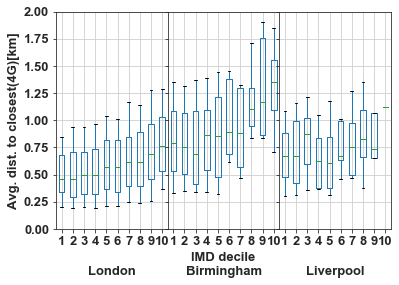

In [174]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.weight':'bold', 'axes.labelweight' : "bold"})

fig, axes = plt.subplots(ncols=3, sharey=True)
fig.subplots_adjust(wspace=0)

for ax, city in zip(axes, ['London', 'Birmingham', 'Liverpool']):
    london_lsoa_2019_gpd[london_lsoa_2019_gpd['city']==city].pivot(columns='IMDDecil', values='avg_distance_to_1_antennas').boxplot(whis=[10,90], showfliers =False,ax=ax)
    ax.margins(0.05) # Optional
    ax.set_ylim([0,2])
    ax.set_xlabel('\n'+city)
axes[0].set_ylabel('Avg. dist. to closest(4G)[km]')
axes[1].set_xlabel('IMD decile\nBirmingham')
fig.savefig('plots/aggsec_lvl_anls_a).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# Fig. 7

In [20]:
# define datasets
london_vdt_loc = 'datasets/VDT/newvdt202002_london.csv'
birmingham_vdt_loc = 'datasets/VDT/newvdt202002_birmingam.csv'
liverpool_vdt_loc = 'datasets/VDT/newvdt202002_liverpool.csv'

london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'
birmingham_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_pd.csv'
liverpool_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_pd.csv'

In [21]:
# load 'em
london_vdt_pd = pd.read_csv(london_vdt_loc, index_col=False)
birmingham_vdt_pd = pd.read_csv(birmingham_vdt_loc, index_col=False)
liverpool_vdt_pd = pd.read_csv(liverpool_vdt_loc, index_col=False)

london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)
birmingham_antenna_imd_pd = pd.read_csv(birmingham_antenna_imd_loc, index_col=False)
liverpool_antenna_imd_pd = pd.read_csv(liverpool_antenna_imd_loc, index_col=False)

In [22]:
# filter the columns we will need 
london_vdt_pd = london_vdt_pd[['lkey','weighted_total_volume','sum_total_volume']]
birmingham_vdt_pd = birmingham_vdt_pd[['lkey','weighted_total_volume','sum_total_volume']]
liverpool_vdt_pd = liverpool_vdt_pd[['lkey','weighted_total_volume','sum_total_volume']]

In [23]:
# join with IMD info
london_vdt_pd = london_vdt_pd.merge(london_antenna_imd_pd, on='lkey', how='inner').drop(columns=['lkey','generation', 'geometry', 'geometry_voronoi']).dropna()
birmingham_vdt_pd = birmingham_vdt_pd.merge(birmingham_antenna_imd_pd, on='lkey', how='inner').drop(columns=['lkey', 'generation', 'geometry', 'geometry_voronoi']).dropna()
liverpool_vdt_pd = liverpool_vdt_pd.merge(liverpool_antenna_imd_pd, on='lkey', how='inner').drop(columns=['lkey', 'generation','geometry', 'geometry_voronoi']).dropna()

In [24]:
for column in ['weighted_total_volume','sum_total_volume']:
    london_vdt_pd[column] = london_vdt_pd[column]/london_vdt_pd[column].quantile(.9)
    birmingham_vdt_pd[column] = birmingham_vdt_pd[column]/birmingham_vdt_pd[column].quantile(.9)
    liverpool_vdt_pd[column] = liverpool_vdt_pd[column]/liverpool_vdt_pd[column].quantile(.9)

In [25]:
london_vdt_pd['city'] = 'London'
birmingham_vdt_pd['city'] = 'Birmingham'
liverpool_vdt_pd['city'] = 'Liverpool'

london_vdt_pd = london_vdt_pd.append(birmingham_vdt_pd, ignore_index=True)
london_vdt_pd = london_vdt_pd.append(liverpool_vdt_pd, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  


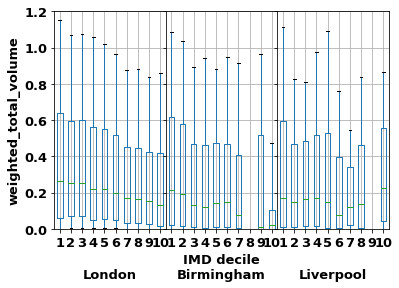

In [32]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13, 'font.weight':'bold', 'axes.labelweight' : "bold"})

fig, axes = plt.subplots(ncols=3, sharey=True)
fig.subplots_adjust(wspace=0)

for ax, city in zip(axes, ['London', 'Birmingham', 'Liverpool']):
    london_vdt_pd[london_vdt_pd['city']==city].pivot(columns='IMDDecil', values='weighted_total_volume').boxplot(whis=[10,90], showfliers =False,ax=ax)
    ax.margins(0.05) # Optional
    ax.set_ylim([0,1.2])
    ax.set_xlabel('\n'+city)
axes[0].set_ylabel('weighted_total_volume')
axes[1].set_xlabel('IMD decile\nBirmingham')
fig.savefig('plots/avg_num_bytes_per_sec_wtv_normalized.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# for ax, city in zip(axes, ['London', 'Birmingham', 'Liverpool']):
#     london_vdt_pd[london_vdt_pd['city']==city].pivot(columns='IMDDecil', values='sum_total_volume').boxplot(whis=[10,90], showfliers =False,ax=ax)
#     ax.margins(0.05) # Optional
#     ax.set_ylim([0,1.3])
#     ax.set_xlabel('\n'+city)
# axes[0].set_ylabel('sum_total_volume')
# axes[1].set_xlabel('IMD decile\nBirmingham')
# fig.savefig('plots/avg_num_bytes_per_sec_stv_normalized.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# Seasonality check for London

In [61]:
london_homeantenna_loc = 'datasets/012020/home_ldn_onlysmartphones.csv'

london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'

MMYYYY_list = ['042019', '072019', '102019', '012020']
london_userperf_loc = ['datasets/042019/userperf_ldn_2019_04.csv', 
                       'datasets/072019/userperf_ldn_2019_07.csv', 
                       'datasets/102019/userperf_ldn_2019_10.csv',
                       'datasets/012020/userperf_ldn_2020_jan.csv']

In [62]:
london_userperf_pd = pd.read_csv(london_userperf_loc[0], index_col=False)
london_userperf_pd['MMYYYY'] = MMYYYY_list[0]
for loc,dt in zip(london_userperf_loc[1:], MMYYYY_list[1:]):
    temp = pd.read_csv(loc, index_col=False)
    temp['MMYYYY'] = dt
    london_userperf_pd = london_userperf_pd.append(temp, ignore_index=True)

In [63]:
london_homeantenna_pd = pd.read_csv(london_homeantenna_loc, index_col=False)
london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)

In [64]:
london_userperf_pd = pd.merge(london_userperf_pd, london_homeantenna_pd, on='device_id', how='inner')
london_userperf_pd = pd.merge(london_userperf_pd, london_antenna_imd_pd, left_on='antenna_id', right_on='lkey', how='inner')

In [65]:
for column in ['avg(rtt4g_avg)', 'avg(retx4g_avg)']:
    for month in MMYYYY_list:
        max_90p = 0        
        for imd_id in range(1, 11):
            imd_90p = london_userperf_pd.loc[(london_userperf_pd['IMDDecil']==imd_id) & (london_userperf_pd['MMYYYY']==month),column].quantile(q=0.9)
            if max_90p < imd_90p:
                max_90p = imd_90p
        london_userperf_pd.loc[london_userperf_pd['MMYYYY']==month,column] = london_userperf_pd.loc[london_userperf_pd['MMYYYY']==month,column].divide(max_90p)
london_userperf_pd['sum(bytes4g)_ratio'] = london_userperf_pd['sum(bytes4g)']/london_userperf_pd['sum(bytesall)']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


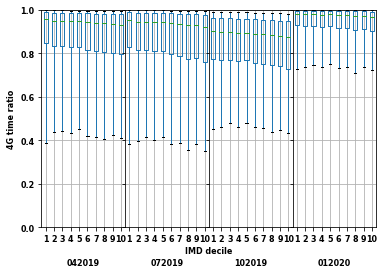

In [69]:
#
# again, uncomment the plot you want to plot/save
#

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8, 'font.weight':'bold', 'axes.labelweight' : "bold"})

fig, axes = plt.subplots(ncols=4, sharey=True)
fig.subplots_adjust(wspace=0)

for ax, month in zip(axes, MMYYYY_list):
    london_userperf_pd[london_userperf_pd['MMYYYY']==month].pivot(columns='IMDDecil', values='sum(bytes4g)_ratio').boxplot(whis=[10,90],showfliers =False,ax=ax)
    ax.margins(0.05) # Optional
    ax.set_ylim([0,1])
    ax.set_xlabel('\n'+month)
axes[0].set_ylabel('4G time ratio')
axes[2].text(-2.3, -0.12, 'IMD decile', fontsize=8)
fig.savefig('plots/nw_quality_acc_soceco_cls_seasonality_lnd_a).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# for ax, month in zip(axes, MMYYYY_list):
#     london_userperf_pd[london_userperf_pd['MMYYYY']==month].pivot(columns='IMDDecil', values='avg(retx4g_avg)').boxplot(whis=[10,90],showfliers =False,ax=ax)
#     ax.margins(0.05) # Optional
#     ax.set_ylim([0,1])
#     ax.set_xlabel('\n'+month)
# axes[0].set_ylabel('Pkt retx [freq]')
# axes[2].text(-2.3, -0.12, 'IMD decile', fontsize=8)
# fig.savefig('plots/nw_quality_acc_soceco_cls_seasonality_lnd_b).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# for ax, month in zip(axes, MMYYYY_list):
#     london_userperf_pd[london_userperf_pd['MMYYYY']==month].pivot(columns='IMDDecil', values='avg(rtt4g_avg)').boxplot(whis=[10,90],showfliers=False,ax=ax)
#     ax.margins(0.05) # Optional
#     ax.set_ylim([0,1])
#     ax.set_xlabel('\n'+month)
# axes[0].set_ylabel('Latency')
# axes[2].text(-2.3, -0.12, 'IMD decile', fontsize=8)
# fig.savefig('plots/nw_quality_acc_soceco_cls_seasonality_lnd_c).pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);